# Recurrent Neural Network - RNN

In order to classify the news in different scenarios, it was necessary to create a deep learning model so that we could automatically interpret, in the ETL stage, what each news item on the infomoney wanted to say.

So it was necessary to create a data set that would feed the model, so I put my little knowlege of the financial market into action, after a failed attempt to use IBM Sentiment Analysis that classified everything as neutral (due to the writers' care not to express an opinion), and I classified 54 Itaú news in 3 scenarious and split it into train, test and dev dataset.

The most famous model of deep learning nlp classifier is the Recurrent Neural Network, in my internship I had been trying different kind of NN models to classifier using the Glove as Embedding, where the RNN was with the best answers.

There are a lot embedding ways to transform word to vectors, so i chose it due my familiarity to tunning this kind of model.


The Glove Embedding used in this RNN is found in NILC - Núcleo Interinstitucional de Linguística Computacional
http://www.nilc.icmc.usp.br/embeddings

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
import unicodedata
import collections
import pandas as pd
import numpy as np
import string
import re

from numpy import random as np_random
from nltk import word_tokenize
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, Flatten
from keras.layers import Reshape, Dropout, Concatenate
from keras.layers import Conv2D, MaxPool2D, Embedding
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Dropout, LSTM, Activation, Bidirectional
from keras.layers.embeddings import Embedding
from sklearn import preprocessing
from sklearn.externals import joblib  

GLOVE_DIR ='glove.6B/'
MAX_SEQUENCE_LENGTH = 50 # Maximum number of words in a sentence
MAX_NB_WORDS = 20000 # Vocabulary size
EMBEDDING_DIM = 50 # Dimensions of Glove word embedding 
VALIDATION_SPLIT = 0.3   # % test dataset

Using TensorFlow backend.
/home/anthony/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


## Pre-processing Functions
One of the most important stage is pre-processing the text that will be classify, it's important we apply the same steps to train and test the model, how it will classify portugues news, I applied removing accentuation and the others commun steps such as remove punction, remove numbers, remove stopwords and lower case.

In [2]:
def strip_accents(sentence):
    try:
        sentence = unicode(sentence, 'utf-8')
    except NameError: # unicode is a default on python 3 
        pass

    sentence = unicodedata.normalize('NFD', sentence)\
           .encode('ascii', 'ignore')\
           .decode("utf-8")
    return str(sentence)

def remove_punction(text):
    no_punct = "".join(c for c in text if c not in string.punctuation)
    return no_punct

def remove_number(text):
    no_number = ''.join([i for i in text if not i.isdigit()])
    return no_number

def lower_caser(text):
    return text.lower()

def remove_stopwords(text):
        tokens = word_tokenize(text)
        tokens = [t for t in tokens if not t in stopwords.words('portuguese')]
        return " ".join(map(str.strip, tokens))


In [3]:
print('Indexing word vectors.')

embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'BR_glove_s50.txt'), encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 275610 word vectors.


In [4]:
# Load the itau news
df = pd.read_csv('balanced_itau_new.csv', sep=';')
df.columns = ['Date','Link','Class','Text']
df = df.sample(frac=1)

In [5]:
df.head()

,Date,Link,Class,Text
20,2019-11-21,https://www.infomoney.com.br/negocios/itau-e-m...,N,"['SÃO PAULO – O Itaú Unibanco (', ') foi multa..."
8,2019-07-01,https://www.infomoney.com.br/mercados/acoes-de...,P,"['SÃO PAULO – Nesta segunda-feira (1), comemor..."
21,2019-07-30,https://www.infomoney.com.br/negocios/acao-do-...,N,['SÃO PAULO – Mais um resultado aparentemente ...
12,2020-04-06,https://www.infomoney.com.br/negocios/itau-e-b...,P,"['SÃO PAULO – Nessa semana, o Bradesco e o Ita..."
2,2019-11-05,https://www.infomoney.com.br/mercados/acao-do-...,P,"['SÃO PAULO – Após abrir a sessão em alta, o '..."


## Balancing the dataset

I balanced the scenarios of the train and test dataset, so I'm using 34 Itaú's news in this stage and 19 in the test dataset, but it will a little far from the ideal because I needed 11 Neutral(NN) news, so I chose to leave it in train dataset.

In [6]:
#### Bar columns of the frequency
Freq_intents = df.groupby(['Class']).size().reset_index(name = 'Freq')
Freq_intents= Freq_intents.sort_values(['Freq'], ascending=False)
Freq_intents = Freq_intents.reset_index()
del Freq_intents['index']     
Freq_intents.head(10)

,Class,Freq
0,N,15
1,P,15
2,NN,4


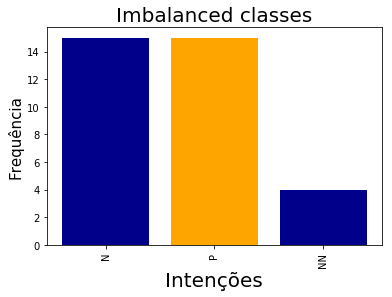

In [7]:
height = Freq_intents['Freq']
bars = Freq_intents['Class']
y_pos = np.arange(len(bars))
plt.bar(y_pos, height, color=['darkblue','orange'])
plt.xlabel('Intenções',fontsize=20)
plt.rcParams['figure.figsize'] = (25,7)
plt.ylabel('Frequência', fontsize=15)
plt.xticks(y_pos, bars, rotation=90, fontsize=10)
plt.title("Imbalanced classes", fontsize=20)
plt.show()

## Pre-processing

Here it will apply all the pre-processing function that was explained above.

In [8]:
df['Text'] = df['Text'].apply(remove_number)
df['Text'] = df['Text'].apply(remove_stopwords)
df['Text'] = df['Text'].apply(lower_caser)
df['Text'] = df['Text'].apply(strip_accents)
df['Text'] = df['Text'].apply(remove_punction)
df = df.reset_index(drop=True)

In [9]:
df.head()

,Date,Link,Class,Text
0,2019-11-21,https://www.infomoney.com.br/negocios/itau-e-m...,N,sao paulo o itau unibanco multado r b...
1,2019-07-01,https://www.infomoney.com.br/mercados/acoes-de...,P,sao paulo nesta segundafeira comemorase a...
2,2019-07-30,https://www.infomoney.com.br/negocios/acao-do-...,N,sao paulo mais resultado aparentemente posit...
3,2020-04-06,https://www.infomoney.com.br/negocios/itau-e-b...,P,sao paulo nessa semana bradesco itau dois ...
4,2019-11-05,https://www.infomoney.com.br/mercados/acao-do-...,P,sao paulo apos abrir sessao alta sessao ...


In [10]:
#### Training dataset
texts = df['Text'][:29]
labels = df['Class'][:29]

#### Test dataset
test_texts = df['Text'][29:]
test_labels = df['Class'][29:]

# Label Encoding: converting text labels into the integers


train_le = preprocessing.LabelEncoder()                                # creating a labelencoder
train_le.fit(labels)                                                   # Array with the intents (labels, it works like Unique function

joblib.dump(train_le, 'label_encoder.pkl')                              # Save the label encoder

labels = train_le.transform(labels)                                         
test_labels = train_le.transform(test_labels)

label_dict = dict(zip(list(train_le.classes_), train_le.transform(list(train_le.classes_))))              ### create a dic "label0 : 0
# print(label_dict)        # show all the labels

#### Tokenizing text and creating word index

In [11]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))             
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# split the data into a training set and a validation set
indices = np.arange(data.shape[0])                 
np.random.shuffle(indices)                         
data = data[indices]                               
labels = labels[indices]                           
num_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

print('Preparing embedding matrix.')

Found 3425 unique tokens.
Shape of data tensor: (29, 50)
Shape of label tensor: (29, 3)
Preparing embedding matrix.


In [12]:
i = len(word_index) + 1
j = EMBEDDING_DIM
num_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.random.randn(i, j)*np.sqrt(2/(49))   ## I will use relu in first hidden layers, so it is recommended to use this multiplier in the random initialize
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding (glove) index will be all-zeros.
        embedding_matrix[i] = embedding_vector[0:50]

## Creating the Sequential model

In this RNN model I create it abusing of the regularizations, to each perceptron of activation function I put a regulation in sequence, so the configuration is:  

1 - Activation function Relu;  
2 - Regularization L1 to remove the features less important;  
3 - Activation function bidirectional Long Short Term Memory(LSTM) with recurrent dropout of 0.1;  
4 - Regularization Dropout of 0.3(keep-probability), it's necessary to cut off randomly the perceptron, the goal is in each iteration run a different model;  
5 - Activation function LSTM;  
6 - Activation function Relu;  
7 - Regularization Dropout of 0.3(keep-probability);  
8 - And the output layer of multi-class classification needs to be a **softmax**;  

I will leave a reference for more details:  

Multi-class classification: https://towardsdatascience.com/multi-label-image-classification-with-neural-network-keras-ddc1ab1afede  

Regularization Droput: https://medium.com/@amarbudhiraja/https-medium-com-amarbudhiraja-learning-less-to-learn-better-dropout-in-deep-machine-learning-74334da4bfc5  

Regularization L1 and L2: https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c  

Activation Functions: https://medium.com/the-theory-of-everything/understanding-activation-functions-in-neural-networks-9491262884e0  



In [13]:
from keras.layers import Dense
from keras.regularizers import l2
from keras.regularizers import l1

embedding_dim=len(embeddings_index['o'])

model = Sequential()
model.add(Embedding(num_words+1, embedding_dim, trainable=True, weights=[embedding_matrix]))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, kernel_regularizer=l1(0.01), bias_regularizer=l1(0.01)))
model.add(Bidirectional(LSTM(128, return_sequences=True, recurrent_dropout=0.1, dropout=0.1), 'concat'))
model.add(Dropout(0.3))
model.add(LSTM(128, return_sequences=False, recurrent_dropout=0.1, dropout=0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(labels.shape[1], activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 50)          171300    
_________________________________________________________________
dense_1 (Dense)              (None, None, 64)          3264      
_________________________________________________________________
dense_2 (Dense)              (None, None, 32)          2080      
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 256)         164864    
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 256)         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense_3 (Dense)              (None, 64)               

## Optimization - Gradient Descent
In the cell below will be defined the optmization method to reduce the cost function, It measure how well the algorithm is going, so despite of it is one line, it's very important and a **priority**. 

The goal is minimize the cost function, reducing the model's error, trying differents Weights and Bias parameters, so it will find the Learning rate that best converges to the minimum local (or minimum global in the best case).

There are 3 most famaous kinds of Gradient Descent: Momentum, RMSprop and ADAM

I prefer chose the ADAM (Adaptive Moment Optimization) that combines the RMSprop+Momentum, where it was the best to my model, but it can change in different models/projects. In below I will leave a link with the 3 kinds GD comparation, where the best was the Momentum.

https://blog.paperspace.com/intro-to-optimization-momentum-rmsprop-adam/#:~:text=So%20far%2C%20we've%20seen,Here%20are%20the%20update%20equations.



In [14]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

### Training the Model

In [15]:
# If you want to train a new model, uncomment the code below and run this cell

history = model.fit(x_train, y_train,
          batch_size=64,
          epochs=100,
          validation_data=(x_val, y_val))
model.save('RNNModel.tflearn')

/home/anthony/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 21 samples, validate on 8 samples
Epoch 1/100
21/21 [==============================] - 2s 102ms/step - loss: 3.5867 - acc: 0.3333 - val_loss: 3.5074 - val_acc: 0.3750
Epoch 2/100
21/21 [==============================] - 0s 5ms/step - loss: 3.5123 - acc: 0.5714 - val_loss: 3.4311 - val_acc: 0.3750
Epoch 3/100
21/21 [==============================] - 0s 5ms/step - loss: 3.4762 - acc: 0.3810 - val_loss: 3.3605 - val_acc: 0.3750
Epoch 4/100
21/21 [==============================] - 0s 6ms/step - loss: 3.4782 - acc: 0.4762 - val_loss: 3.3122 - val_acc: 0.3750
Epoch 5/100
21/21 [==============================] - 0s 6ms/step - loss: 3.4574 - acc: 0.3810 - val_loss: 3.2799 - val_acc: 0.2500
Epoch 6/100
21/21 [==============================] - 0s 6ms/step - loss: 3.3904 - acc: 0.3810 - val_loss: 3.2560 - val_acc: 0.1250
Epoch 7/100
21/21 [==============================] - 0s 6ms/step - loss: 3.3952 - acc: 0.3810 - val_loss: 3.2529 - val_acc: 0.1250
Epoch 8/100
21/21 [===================

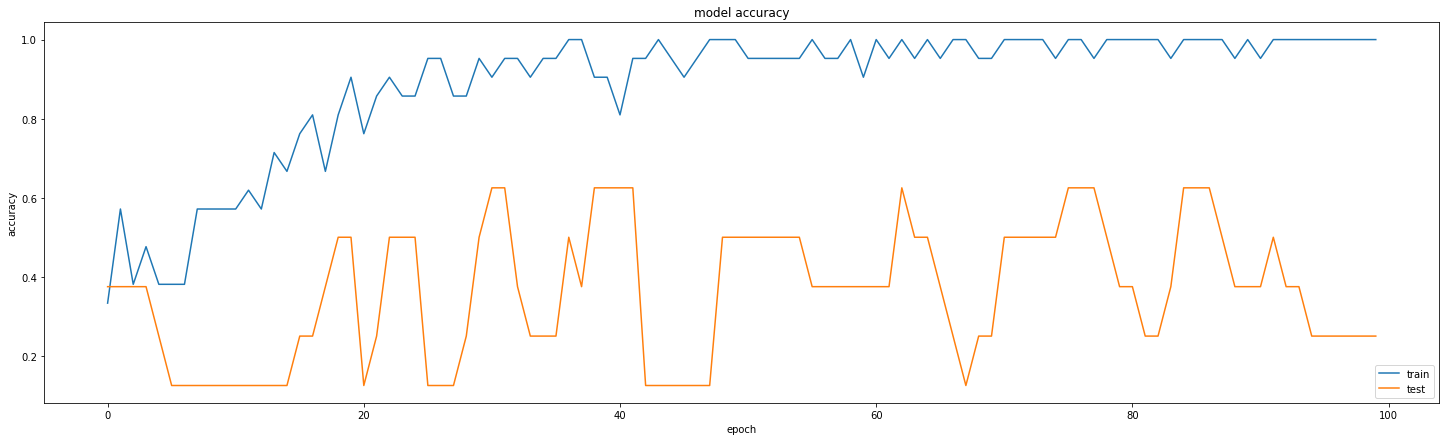

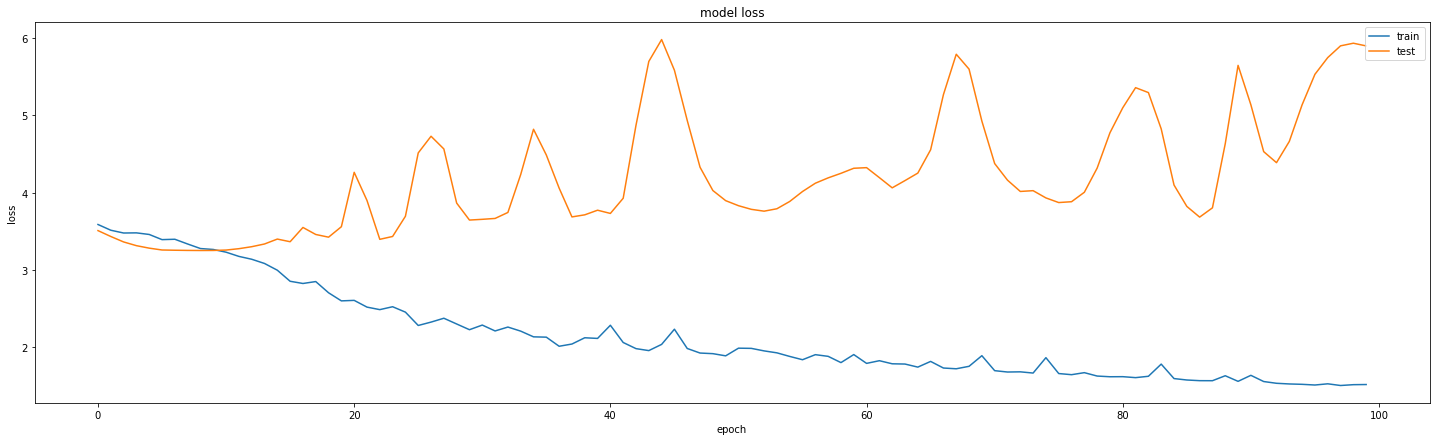

In [16]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

Despite the explosion of loss through the amount of epochs, with this optimization was that obtained the best F1-score in the test and dev set.
I had been try the SGD, RMSprop, Adadelta and Nadam and my F1-score dropped to 0.2 and get a vicious model to classify everything as a positive scenarios.

The keras documentation for the available optimizers: https://keras.io/api/optimizers/

In [17]:
## Loading the already trained model - if you have a model .tflearn format
from keras.models import load_model
model = load_model('RNNModel.tflearn')

#### Test dataset evaluation

In [18]:
test_sequences = tokenizer.texts_to_sequences(test_texts)
test_input = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

# Get predictions
test_predictions_probas = model.predict(test_input)
test_predictions = test_predictions_probas.argmax(axis=-1)    #### get the prob and put the classes

In [19]:
from sklearn.metrics import classification_report

test_intent_predictions = train_le.inverse_transform(test_predictions)
test_intent_original = train_le.inverse_transform(test_labels)

# IT sum the number of test_intent_predictions(classe, AddToPlaylist...) equal test_intent_original and divide by total tests
print('accuracy: ', sum(test_intent_predictions == test_intent_original) / len(test_labels))
print("Precision, Recall and F1-Score:\n\n", classification_report(test_intent_original, test_intent_predictions))

accuracy:  0.6
Precision, Recall and F1-Score:

               precision    recall  f1-score   support

           N       0.50      0.50      0.50         2
           P       0.67      0.67      0.67         3

    accuracy                           0.60         5
   macro avg       0.58      0.58      0.58         5
weighted avg       0.60      0.60      0.60         5



In [20]:
# Função
def RNN(Frase):

    test_texts = [Frase]
    test_sequences = tokenizer.texts_to_sequences(test_texts)
    test_input = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
    test_predictions_probas = model.predict(test_input)
    test_predictions = test_predictions_probas.argmax(axis=-1)
    test_intent_predictions = train_le.inverse_transform(test_predictions)
    test_intent_original = train_le.inverse_transform(test_labels)
    df_probas = pd.DataFrame(test_predictions_probas)
    df_intent = pd.DataFrame(test_intent_predictions)
    frames = [df_probas, df_intent]
    result = pd.concat(frames)
    result = pd.concat([df_probas, df_intent], axis=1)
    x = result.transpose()[0:104]     ### get the intent list
    x.columns = ['probability']
    x = pd.to_numeric(x['probability'][:3])
    x = pd.DataFrame(x)
    labels = pd.DataFrame.from_dict(label_dict,orient='index')
    labels = labels.reset_index()
    labels.columns = ['Labels','number']
    result_table= labels.join(x)
    #np.sort(result_table['probability'].values)
    result_table = result_table.sort_values(by=['probability'], ascending = False)
    result_table.head(5)
    return result_table.head(5)

## TESTING

In [21]:
# Load the TEST itau news
df_test = pd.read_csv('test_itau_new.csv', sep=';')
df_test.columns = ['Date','Link','Class','Text']
df_test = df_test.sample(frac=1)


In [22]:
df_test.shape

(19, 4)

In [23]:
df_test['Text'] = df_test['Text'].apply(remove_number)
df_test['Text'] = df_test['Text'].apply(remove_stopwords)
df_test['Text'] = df_test['Text'].apply(lower_caser)
df_test['Text'] = df_test['Text'].apply(strip_accents)
df_test['Text'] = df_test['Text'].apply(remove_punction)
df_test = df_test.reset_index(drop=True)

In [24]:
df_test = pd.DataFrame(df_test, columns = ['Date','Link','Class','Text','RNN_Class'])

In [25]:
for i,x in enumerate(df_test.iterrows()):
    x = RNN(df_test['Text'][i]).reset_index(drop = True)
    pred = x['Labels'][0]
    df_test['RNN_Class'][i] = str(pred)

/home/anthony/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/anthony/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [26]:
df_test.head(50)

,Date,Link,Class,Text,RNN_Class
0,2020-01-03,https://www.infomoney.com.br/minhas-financas/c...,P,sao paulo a partir segundafeira bancos br...,P
1,2019-05-10,https://www.infomoney.com.br/mercados/como-com...,P,maior banco pais itau costuma desta...,P
2,2019-08-14,https://www.infomoney.com.br/consumo/itau-lanc...,P,sao paulo o itau unibanco informou prim...,P
3,2020-04-22,https://www.infomoney.com.br/minhas-financas/i...,P,sao paulo o itau unibanco anunciou vai prorr...,P
4,2020-04-17,https://www.infomoney.com.br/negocios/diferent...,P,sao paulo uma consequencias atual crise novo...,P
5,2020-02-11,https://www.infomoney.com.br/mercados/ceo-do-i...,P,sao paulo mais resultado grande banco bem re...,N
6,2020-02-03,https://www.infomoney.com.br/onde-investir/ita...,P,sao paulo focado segmento acoes empresas...,P
7,2020-05-05,https://www.infomoney.com.br/mercados/preparad...,P,sao paulo bem preparado guerra contra corona...,N
8,2020-01-23,https://www.infomoney.com.br/minhas-financas/i...,N,sao paulo o itau unibanco maior banco brasi...,P
9,2020-03-24,https://www.infomoney.com.br/mercados/itau-bba...,P,sao paulo o itau bba cortou projecao ibovesp...,N


In [27]:
from sklearn.metrics import f1_score
prec1 = f1_score(df_test['Class'], df_test['RNN_Class'], average='weighted')
prec1

0.6519524617996605

## Conclusion

In spite of the model has a consider loss and low accuracy, the F1-score is acceptable using F1-score Weighted (0.65 out of 1) in the last test, the model nailed it the biggest news from Itaú in this year, where itaú donated 1 Billion to combat the covid-19 pandemic (row number 18), that was the biggest donation in the history of Brazil.

There's a lot of test to do, and If I need to tune more this model I will start adding more data (hahaha) and after applying the bias-variance method again.